### Building LLAMA using pytorch 


##### Major differences wrt GPT

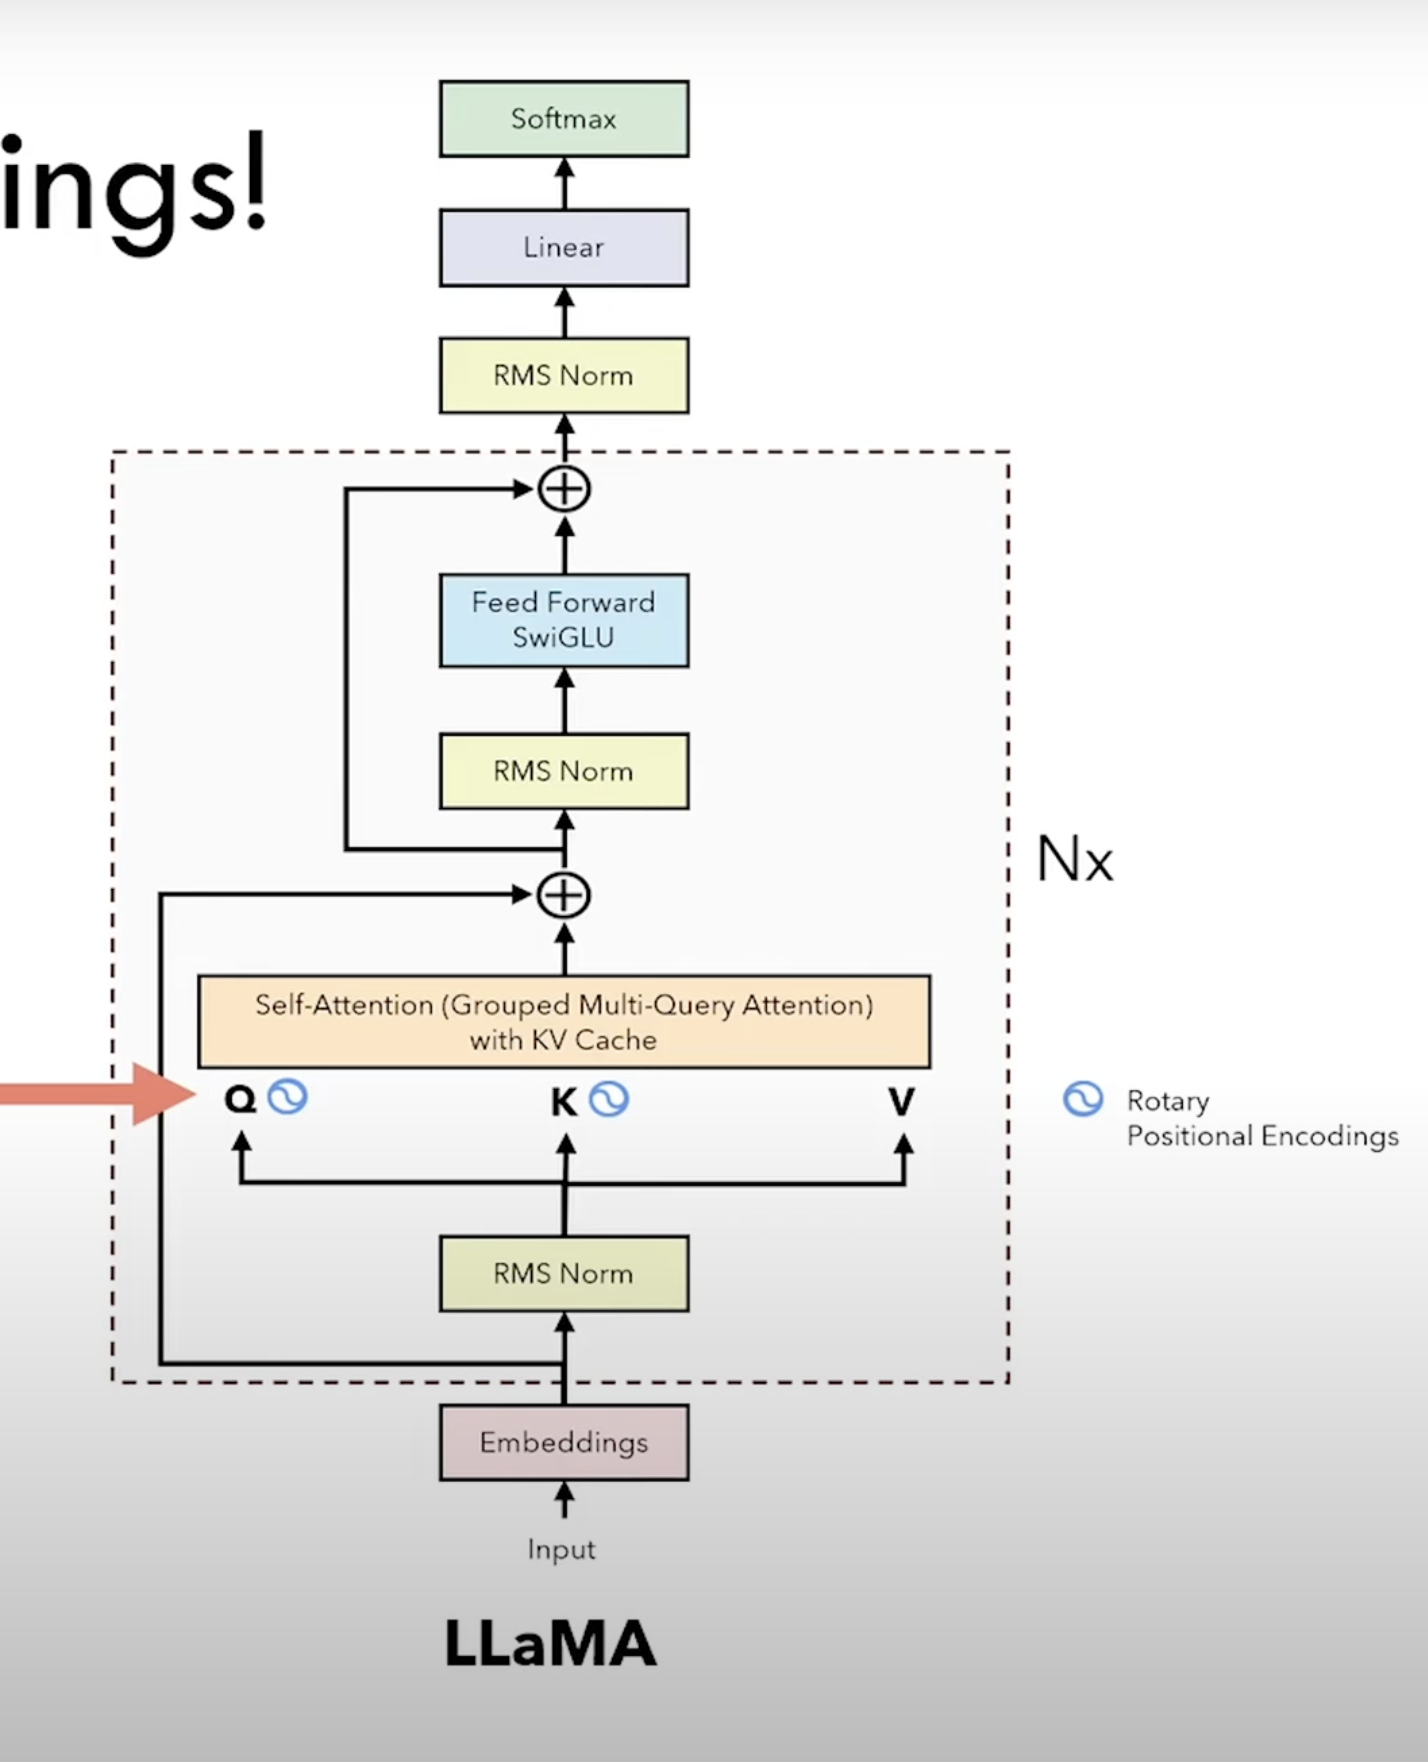

source: Umar Jamil


- **RMSNorm**: LLaMA uses Root Mean Square Layer Normalization (RMSNorm) instead of the standard LayerNorm used in Transformers and GPT. RMSNorm is simpler and computationally cheaper, as it normalizes based on the root mean square of the input, avoiding the need to compute mean and variance

- **SwiGLU Activation**: Instead of the ReLU or GELU activations used in GPT, LLaMA employs SwiGLU (a variant of the Swish activation combined with Gated Linear Units), which improves performance by allowing the model to learn more complex patterns.

- **Rotary Positional Embeddings (RoPE)**: Unlike absolute positional encodings (used in early Transformers) or learned positional embeddings (used in GPT), LLaMA uses Rotary Positional Embeddings. RoPE applies a rotation matrix to the query and key vectors in attention, encoding relative positions more effectively and reducing memory usage.



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math, time
from dataclasses import dataclass
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
@dataclass
class ModelConfig:
    d_model = 128
    seq_len = 32
    batch_size = 2
    n_blocks = 6
    q_heads = 8
    kv_heads = 4
    vocab_size = 64 # set later
    eps = 1e-6
    

config = ModelConfig()

In [7]:
## load data and tokenize
data_path = "../data/hp_book1.txt"
txt = open(data_path).read()
chars = sorted(list(set(txt)))
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}
tokenizer = stoi

# train-val 
encode = lambda x: [tokenizer[i] for i in x]
decode = lambda x: ''.join( [itos[i] for i in x] )
data = torch.tensor(encode(txt), dtype=torch.long)

In [8]:
config.vocab_size = len(tokenizer)
config.tokenizer = tokenizer

In [9]:
train = data[:int( len(txt)*0.9 ) ] 
val = data[int( len(txt)*0.9 ): ]

def get_batch_data(mode):
    data = train if mode == 'train' else val
    idx = torch.randint( len(data) - config.seq_len, (config.batch_size,) )
    
    x = torch.stack( [ data[i:i+config.seq_len] for i in idx] )
    y = torch.stack( [ data[i+1:i+config.seq_len+1] for i in idx] )
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x,y 

x, y = get_batch_data(mode='train')

In [10]:
class RMSNorm(nn.Module):
    """
    Refer formula; shape in - shape out
    1. calculate rms_norm 
    2. x * rms_norm * gain
    """
    def __init__(self, config):
        super().__init__()
        self.eps = config.eps
        self.gain = nn.Parameter(torch.ones(config.d_model)) # gain param like gamma in layerNorm
    
    def _norm(self, x):
        """
        RMS norm across emb dim/ feature layer
        """
        rms = torch.rsqrt( torch.mean(x**2, dim=-1, keepdim=True) + self.eps ) # 1/sqrt
        x_norm = x * rms
        return x_norm

    def forward(self, x):
        x_norm = self._norm(x.float()).type_as(x) # from any mixed precision to high precision float
        return self.gain * x_norm

test = torch.randn((2, 4, 128))
rms = RMSNorm(config=config)
rms(test).shape

torch.Size([2, 4, 128])

In [11]:
class RoPE(nn.Module):
    def __init__(self, config):
        super().__init__()

    def forward(self, x):
        return x

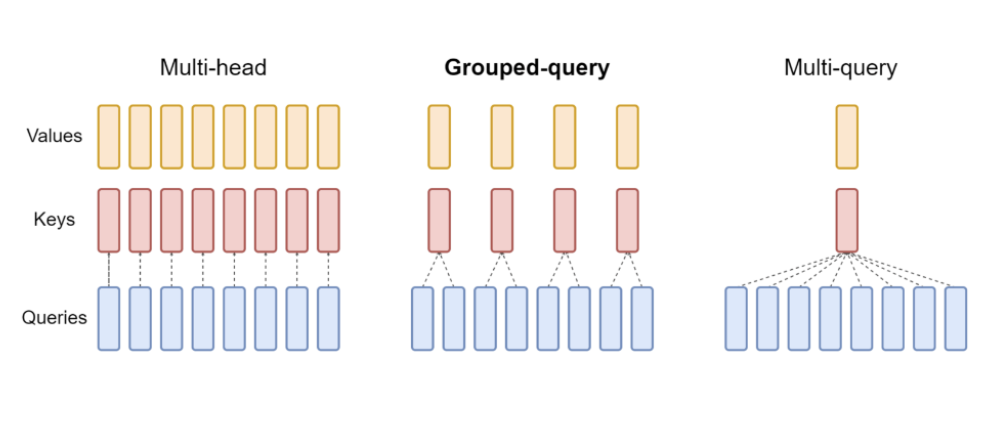


In [30]:
def apply_rotary_emb(q, k, freq):
    return q, k

In [38]:
class GQA(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.q_heads = config.q_heads
        self.kv_heads = config.kv_heads
        self.head_dim = config.d_model // self.q_heads
        self.n_groups = self.q_heads // self.kv_heads

        self.q_proj =  nn.Linear(config.d_model, self.q_heads * self.head_dim , bias=False)
        self.k_proj =  nn.Linear(config.d_model, self.kv_heads * self.head_dim, bias=False)
        self.v_proj =  nn.Linear(config.d_model, self.kv_heads * self.head_dim, bias=False)
        self.out_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.freqs_cis = torch.randn(config.seq_len)   # TODO
        
        self.register_buffer('trill', torch.tril(torch.ones((config.seq_len, config.seq_len))), persistent=False)
        self.k_cache = None
        self.v_cache = None
        self.seq_len = config.seq_len

    def forward(self, x, step=None):
        B, T, C = x.shape
        # q(x)       -> B T C -> B T C
        # k(x), v(x) -> B T C -> B T (C// self.n_groups)
        # split C -> n_heads * heads_dim
        q, k, v = (
            self.q_proj(x).reshape( B, T, self.q_heads, self.head_dim ),
            self.k_proj(x).reshape( B, T, self.kv_heads, self.head_dim ),
            self.v_proj(x).reshape( B, T, self.kv_heads, self.head_dim ),
        )
        q, k = apply_rotary_emb(q, k, self.freqs_cis[:T])

        ## use kv cache
        if step is not None:
            if self.k_cache is None:
                self.k_cache = torch.zeros(B, self.seq_len, self.kv_heads, self.head_dim, device=x.device)
                self.v_cache = torch.zeros(B, self.seq_len, self.kv_heads, self.head_dim, device=x.device)

            self.k_cache[:, step:step+T] = k
            self.v_cache[:, step:step+T] = v
            k = self.k_cache[:, :step+T]
            v = self.v_cache[:, :step+T]

        # since C of k and v is less, repeat in heads dim.
        k = k.repeat_interleave(self.n_groups, dim=2)
        v = v.repeat_interleave(self.n_groups, dim=2)

        ## swap head and T
        q, k, v = q.transpose(1,2), k.transpose(1,2), v.transpose(1,2)

        ## causal attn
        attn = ( q @ k.transpose(-2,-1) ) * (self.head_dim ** -0.5)
        if step is None:
            attn = attn.masked_fill(self.trill[:T, :T] == 0, float("-inf"))
        else:
            mask = self.trill[:attn.size(-2), :attn.size(-1)].to(x.device)
            attn = attn.masked_fill(mask == 0, float("-inf"))

        attn = F.softmax(attn, dim=-1)
        out = attn @ v
        
        # swap H, T and then back to B T C
        out = out.transpose(1, 2).reshape(B, T, C)
        return self.out_proj(out)

x = torch.rand( 2, 8, 128 )
gqa = GQA(config=config)
gqa(x).shape

torch.Size([2, 8, 128])

* LLaMA replaces the usual Transformer FFN’s **GELU** with a **SwiGLU** (Swish-Gated Linear Unit).
* Standard Transformer FFN:

$$
\text{FFN}(x) = W_2 \, \text{activation}(W_1 x) 
$$

* SwiGLU variation:

$$
\text{FFN}(x) = W_2 \, [\text{Swish}(W_1 x) \odot (W_3 x)]
$$

* `W1` → produces the **activation branch**.
* `W3` → produces the **gate branch**.
* Swish = `x * sigmoid(x)` (PyTorch’s `F.silu`).
* Elementwise multiply (`*`) gates one branch with the other.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        hddn_dim = 8 * config.d_model/ 3
        if config.ffn_multiplier is not None:
            hddn_dim = int( config.ffn_multiplier * hddn_dim )
        ## round off 
        hddn_dim = config.muliple_of * (( hddn_dim + config.muliple_of -1 ) // config.muliple_of )
        ## lin layers
        self.w1 = nn.Linear(config.d_model, hddn_dim, bias=False )
        self.w2 = nn.Linear(hddn_dim, config.d_model, bias=False )
        self.w3 = nn.Linear(config.d_model, hddn_dim, bias=False )

    def forward(self, x):
        swish = F.silu(self.w1(x))          # B T hddn 
        return self.w2( self.w3(x) * swish) # B T hddn -> B T d_model

In [22]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn_norm = RMSNorm(config=config)
        self.attn = GQA(config=config)
        self.ff_norm = RMSNorm(config=config)
        self.ff = FeedForward(config=config)
    
    def forward(self, x):
        """
        receives (B T C)
        returns (B T C)
        """
        ## refer diagram for the logic below.
        x = x + self.attn( self.attn_norm(x) )
        x = x + self.ff_norm( self.ff(x) )
        return x

In [ ]:
class LLAMAModel(nn.Module):

    config = config

    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.Sequential(* [Block(config=config) for _ in range(config.n_blocks) ] )
        self.out_norm = RMSNorm(config)
        self.out_proj = nn.Linear( config.d_model , config.vocab_size )

    def forward(self, X, targets=None):
        """
        B: Batch; T: time_step/ seq_len; C: Channel/ emb_dim/ d_model
        """
        B, T = X.shape

        x = self.tok_emb(X)         # (B T C)
        x = self.blocks(x)          # (B T C)
        x = self.out_norm(x)        # (B T C)
        logits = self.out_proj(x)   # (B T vc)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)    # (B', C)
            targets = targets.view(B * T)   # (B', 1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


model = LLAMAModel()
model(x)[0]

tensor([[[-0.2486, -0.2951,  0.0764,  ...,  0.3133,  0.2700,  0.2857],
         [ 0.1190,  0.5461,  0.3458,  ..., -0.3693, -0.1490, -0.1029],
         [-0.7629,  0.0697,  0.7142,  ..., -0.3917, -0.6995,  0.9233],
         ...,
         [ 0.2454, -0.1409, -0.0496,  ..., -0.4819,  0.6935,  0.2244],
         [ 0.1613,  0.5192, -0.5796,  ...,  0.0777,  0.7574,  0.3496],
         [ 0.2688,  0.1033,  0.4005,  ...,  1.0201,  0.3685, -0.1085]],

        [[ 0.1190,  0.5461,  0.3458,  ..., -0.3693, -0.1490, -0.1029],
         [ 0.5499,  0.9070,  0.1893,  ...,  0.3393,  0.0293, -0.1555],
         [ 0.5499,  0.9070,  0.1893,  ...,  0.3393,  0.0293, -0.1555],
         ...,
         [-0.2486, -0.2951,  0.0764,  ...,  0.3133,  0.2700,  0.2857],
         [ 0.2642,  0.6069, -1.1707,  ...,  0.4594, -0.2075,  0.2521],
         [ 0.2688,  0.1033,  0.4005,  ...,  1.0201,  0.3685, -0.1085]]],
       grad_fn=<ViewBackward0>)